## Name: Franklin Limaico

# Homework 3: Star formation in galaxies

The homework should be submitted as a python notebook. Make all the plots in the python notebook.

Please email the homework to hdenes@yachaytech.edu.ec by the <b>end of the day (midnight) by the 15th of December.</b>

Total points: 20

Please let me know if you have any questions. 

<b>Important notes: </b> 
- The tutorial notebooks contain the methods that you can use to solve the homework. 
- If you have problems with some of the specific astrophysics packages, make sure to check the versions. Not all versions of the packages are compatible with each other. 

## (20 points) Analysing star formation properties of galaxies 

First dwonload the relevant data from the Sloan DIgital Sky Survey (SDSS) data base. The code for this is provided. In the cell below.  

- The SpecObj table contains basic information about the observation and the object, such as the redshift. 
- The galaxy table provides useful photometric measurements for colors and images. 
- The three GalSpec table each give products derived from spectroscopy. 

The H $\alpha$ emission line is a convienient indicator of the star formation rate. 

We want galaxies with quality measurements of this line strength, so a S/N restriction is specified. We also want the H $\beta$ emission line, because as we will see below, this will assist us in accounting for dust absorption along our line of sight.

In [144]:
# Import relevant libraries

import pandas as pd # data analysis 
import numpy as np # more data analysis

from matplotlib import pyplot as plt # another plotting library
from matplotlib.image import imread

from astropy.constants import c # useful constants
from astropy import units as u # useful for unit conversions
from astropy import coordinates as coords
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.io import ascii

from astroquery.sdss import SDSS
from astroquery.simbad import Simbad

# Python standard-libraries to download data from the web
from urllib.parse import urlencode
from urllib.request import urlretrieve

#only here to display images
from IPython.display import Image

In [145]:
# Create a query to fetch star forming galaxies

query = 'SELECT TOP 10000 s.plate, s.fiberid, s.mjd, s.ra, s.dec, s.z, s.zwarning, '
query += 'g.h_beta_flux, g.h_alpha_flux, '
query += 'g.h_beta_flux_err, g.h_alpha_flux_err, '
query += 'e.bptclass, e.lgm_tot_p50, '
query += 'i.lick_hd_a_sub, i.d4000_n_sub, '
query += 'i.lick_hd_a_sub_err, i.d4000_n_sub_err, '
query += 'p.petror90_r '
query += 'FROM GalSpecLine AS g, SpecObj AS s, GalSpecExtra AS e, GalSpecIndx AS i, galaxy AS p ' 
query += 'WHERE '
query += 's.specobjid = g.specobjid '
query += 'AND s.specobjid = e.specobjid '
query += 'AND s.specobjid = i.specobjid '
query += 'AND s.bestobjid = p.objid '
query += 'AND bptclass = 1 '
query += 'AND s.z BETWEEN 0.04 and 0.1 '#-- Lower limit needed for global parameters w/ small aperture
query += 'AND h_alpha_flux > h_alpha_flux_err*5.0 ' #-- Make sure Balmer lines have adequate S/N
query += 'AND h_beta_flux > h_beta_flux_err*5.0 '
query += 'AND d4000_n_sub > d4000_n_sub_err*5.0 '
query += 'AND h_alpha_flux_err > 0 ' #-- Consistency check
query += 'AND h_beta_flux_err > 0 '
query += 'AND h_alpha_flux > 2.7*h_beta_flux ' #-- Ensures proper continuum subtraction
query += 'AND lgm_tot_p50 > 0 '
query += 'AND sigma_balmer < 509.55 ' #-- Exclude the broad line emitting galaxies
query += 'AND s.class = \'GALAXY\' '  #-- Looking for galaxies, not stars
query += 'AND s.zwarning = 0 '
#print (query) # useful for debugging, remove first # to uncomment

# send query to SDSS
gals = SDSS.query_sql(query,data_release=16)

gals

plate,fiberid,mjd,ra,dec,z,zwarning,h_beta_flux,h_alpha_flux,h_beta_flux_err,h_alpha_flux_err,bptclass,lgm_tot_p50,lick_hd_a_sub,d4000_n_sub,lick_hd_a_sub_err,d4000_n_sub_err,petror90_r
int64,int64,int64,float64,float64,float64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
327,287,52294,172.9785,-3.460363,0.074,0,38.88356,143.1628,1.962683,2.514851,1,10.14489,4.467962,1.219838,1.198281,0.0254548,8.838215
339,81,51692,196.1818,-3.4515413,0.0764561,0,152.4977,509.0274,3.268146,4.947786,1,10.08973,5.643977,1.223664,0.7961217,0.017084,6.626981
334,460,51993,187.38695,-1.7156659,0.08318656,0,71.41663,292.5707,2.657821,3.528389,1,10.02382,7.499817,1.272964,1.74312,0.0408858,6.046188
288,220,52000,184.67267,-1.256172,0.08030983,0,35.78695,152.2864,2.047672,2.514481,1,10.17186,6.056723,1.401293,1.479805,0.04000361,7.443798
338,104,51694,195.55476,-2.7308406,0.06682059,0,30.03271,112.1453,2.068128,2.389887,1,10.28536,2.018528,1.468142,1.7718,0.04822052,9.842375
467,299,51901,130.58952,0.085904147,0.07649653,0,63.97259,219.3852,2.201756,3.001429,1,9.527237,5.873466,1.174114,1.153155,0.02298255,4.850787
602,368,52072,195.39459,65.74269,0.08309618,0,186.3237,688.569,3.545641,6.096018,1,10.02797,4.951219,1.192541,0.7512083,0.01545298,2.906462
450,139,51908,136.84324,53.984189,0.08064698,0,62.31424,269.4473,1.507196,2.162988,1,10.07051,5.334502,1.232791,0.7728633,0.01699663,6.590944
453,197,51915,146.19562,58.797473,0.04146267,0,59.00877,266.1819,2.318659,3.345441,1,10.18141,3.252721,1.39704,0.7759885,0.02202449,6.815051


### Dereddening the Spectrum

In order to determine the star formation rate (SFR) in each galaxy, we need to get the H $\alpha$ luminosity L($H\alpha$) emitted from each galaxy. The SQL query gives us the observed flux F(H $\alpha$), but this doesn’t account for dust absorbing some of this light as it travels from a galaxy to the point of observation. Fortunately, we can correct for this “extinction” by making use of the fact that dust preferentially absorbs shorter wavelength light to “deredden” the spectrum. In ideal conditions without dust, we can assume that 
F(H $\alpha$)/F(H $\beta$) = 2.86 in star forming regions. Let’s deredden the H $\alpha$ flux.

In [146]:
# Deredden emission lines according to Calzetii+ 2000
# wavelength supplied in angstroms
# wl : wavelenght
# kwl : wavenumber

def deredden(lum,wl,Hb,Ha):
    if (wl >= 6300 and wl <= 22000):
        wl = wl/1e4 # convert to microns
        kwl = 2.659*(-1.857+1.040/wl)+4.05
    elif (wl >= 1200 and wl < 6300):
        wl = wl/1e4 # convert to microns
        kwl = 2.659*(-2.156+1.509/wl-0.198/wl**2+0.011/wl**3)+4.05
    else:
        print ('Wavelength of range')
    
    # Using k-values calc as above
    kHa = 3.326
    kHb = 4.598
    
    ebmv = 2.5/(kHb-kHa)*np.log10(Ha/Hb/2.86) # 2.86 for SF; 3.1 for AGN
    lum_dr = lum*10**(0.4*kwl*ebmv)
    
    return lum_dr

####

Halpha_flux = gals['h_alpha_flux']
Hbeta_flux = gals['h_beta_flux']

#The actual H alpha flux
Halpha_flux_dr = deredden(Halpha_flux,6563,Hbeta_flux,Halpha_flux)

According to the GalSpecLine table, the line flux is returned as $10^{-17}$ $erg/s/cm^2$, so we first need to multiply our dereddened F(H) by $10^{-17}$ to get actual flux value. Luminosity has units of energy / second, and an erg is a unit of energy. 

1) Calcualte the distance to the galaxies in the sample in cm. Make sure to clarify which hubble constant you are using. 

2) Convert the H$\alpha$ flux into H$\alpha$ luminosity.

Hint, the relavant relations are covered in the lecture slides. Astropy also has functions that are very helpful for calculating distances. 

We can now use the L(H$\alpha$) to determine the SFR in units of M$_{\odot}$/yr using the conversion from Kennicutt+ 1998.

$$\frac{SFR}{M_{\odot} yr^{-1}} = \frac{L(H\alpha)}{1.26 \times 10^{41} ergs \ s^{-1}}$$

3) Calcualte the star formation rate as $log_{10}(SFR)$. Make a histogram of $log_{10}(SFR)$. How is the distribution of the star formation rate?  

## Solution

**According to the GalSpecLine table, the line flux is returned as $10^{-17}$ $erg/s/cm^2$, so we first need to multiply our dereddened F(H) by $10^{-17}$ to get actual flux value. Luminosity has units of energy / second, and an erg is a unit of energy.**

In [147]:
#print(Halpha_flux_dr)

# Multiply the rededdened Flux of H by 10^-7

Halpha_flux_actual = Halpha_flux_dr*(10**-17)

print("The array of H alpha flux (erg/s/cm^2) is:")
print(Halpha_flux_actual)

The array of H alpha flux (erg/s/cm^2) is:
     h_alpha_flux     
----------------------
 2.771080971993831e-15
 7.624531574921717e-15
 7.486568714983656e-15
 4.303950898253129e-15
2.2522045986943683e-15
3.5266575032609025e-15
1.3458282567610457e-14
   7.9405740572937e-15
 8.761961830049012e-15
3.4720230451004743e-15
                   ...
 1.344668210841246e-15
1.2406478917066552e-14
2.6720079513046136e-15
 3.882205924344747e-15
  4.34722718717995e-14
1.0870417512215716e-14
1.0127065249447647e-14
 5.918852445253863e-15
1.1149437464229858e-15
 6.078995177022006e-15
 3.793715620906434e-15
Length = 10000 rows


**1) Calculate the distance to the galaxies in the sample in cm. Make sure to clarify which hubble constant you are using.**

Applying the Hubble Law to calculate the distances to the galaxies. The Hubble law is:

$$
z = \frac{\lambda_{obs} - \lambda_{rest}}{\lambda_{rest}} = \frac{H_0}{c}D
$$

where:

$z$ is the redshift, an adimensional parameter

$H_0 = 71 \pm 4$ $km\,s^{-1}\,Mpc^{-1}$ is the Hubble Constant

$c\,=\,3*10^{8}\,m/s\,=\,3*10^{5}\,km/s$ is the speed of light

$D$ is the proper distance, in Megaparsecs ($Mpc$)

So, the equation for the proper distance of the Galaxy (in cm) is:

$$
D = \frac{c}{H_0}z
$$

where:

$H_0 = 71\,km\,s^{-1}\,Mpc^{-1}*\frac{1 Mpc}{3.0857*10^{24}cm}$

the other parameters has the same units!

In [148]:
#Parameters:

H0 = 71/(3.0857*(10**24)) #km*s^-1*cm^-1

c = 3*(10**5) #km/s

print("The Hubble constant is H_0 =", H0,"km*s^-1*cm^-1")
print("The speed of light is c =", c,"km*s^-1")

The Hubble constant is H_0 = 2.3009365784100852e-23 km*s^-1*cm^-1
The speed of light is c = 300000 km*s^-1


In [149]:
# Reshift data:
galaxies_redshift = gals['z']

#print(galaxies_redshift)

In [150]:
#Proper distance array:
galaxies_prop_dist = galaxies_redshift*(c/H0)

print("The proper distances of the galaxies (cm) are:")
print(galaxies_prop_dist)


The proper distances of the galaxies (cm) are:
          z           
----------------------
 9.648245070422534e+26
 9.968475539577465e+26
1.0846004289802817e+27
1.0470931370323943e+27
  8.71218146040845e+26
 9.973746871309858e+26
1.0834220392647887e+27
1.0514889557154928e+27
 5.405972992352112e+26
 5.560829933366197e+26
                   ...
 8.132551403450703e+26
 7.019514206323943e+26
1.1024751067901409e+27
1.1132833577577464e+27
 6.385091244084507e+26
 7.761489024760563e+26
 7.547107626929577e+26
 7.876643437309859e+26
 7.497059311352112e+26
 7.658604833070423e+26
1.2186346317887324e+27
Length = 10000 rows


**2) Convert the H $\alpha$ flux into H $\alpha$ luminosity.**

Hint, the relavant relations are covered in the lecture slides. Astropy also has functions that are very helpful for calculating distances. 


The $F(H\alpha)$ units are the same as the Total Flux ($W/m^2 = J/s/m$) but with different names which are equivalents i.e. $erg/s/cm^{2}$. So, the relation to get the Luminosity is: 

$$
L(H\alpha) = 4\,\pi\,d^{2} \int_{\nu_1}^{\nu_1}F_{\nu}\,d\nu \\
\\
L(H\alpha) = 4\,\pi\,d^2\,F(H\alpha)
$$

where

$F(H\alpha)$ units are ($erg/s/cm^{2}$)

$d^2$ unit is ($cm^2$) 

$L(H\alpha)$ units are ($erg/s$)

In [151]:
#Here we have the actual H alpha Flux
#print(Halpha_flux_actual)

#H alpha luminosity

H_alpha_lum = 4*np.pi*(galaxies_prop_dist**2)*Halpha_flux_actual

print("The alpha luminosity array (erg/s) is:")
print(H_alpha_lum)


The alpha luminosity array (erg/s) is:
          z           
----------------------
 3.241572450527684e+40
  9.52095530419934e+40
1.1067058939163638e+41
 5.929905852612782e+40
2.1481842588147703e+40
 4.408489718408469e+40
  1.98515690275014e+41
 1.103243037802472e+41
3.2177993846979686e+40
1.3491855763192753e+40
                   ...
1.1175800380970301e+40
 7.681968473626991e+40
 4.081174782471512e+40
  6.04644164645538e+40
 2.227185634559337e+41
 8.228983362542053e+40
 7.248607080743676e+40
 4.614554181212225e+40
 7.874893939735258e+39
 4.480649637780874e+40
7.0798110764403735e+40
Length = 10000 rows


We can now use the L(H $\alpha$) to determine the SFR in units of M $_{\odot}$/yr using the conversion from Kennicutt+ 1998.

$$\frac{SFR}{M_{\odot} yr^{-1}} = \frac{L(H\alpha)}{1.26 \times 10^{41} ergs \ s^{-1}}$$

In [152]:
#Now, determine the SFR in units of Solar Mases/year

SFR = H_alpha_lum/(1.26*(10**41)) #Solar Mases/yr

print("The SFR array (Solar Mases/yr) is:")
print(SFR)

The SFR array (Solar Mases/yr) is:
         z          
--------------------
 0.25726765480378444
   0.755631373349154
  0.8783380110447331
 0.47062744862006206
 0.17049081419164844
  0.3498801363816245
  1.5755213513889998
  0.8755897125416444
 0.25538090354745785
 0.10707822034279962
                 ...
 0.08869682842039922
  0.6096800375894438
 0.32390276051361205
 0.47987632114725237
  1.7676076464756643
  0.6530939176620677
  0.5752862762494981
 0.36623445882636707
0.062499158251867123
 0.35560711410959317
  0.5618897679714582
Length = 10000 rows


**3) Calculate the star formation rate as $log_{10}(SFR)$. Make a histogram of $log_{10}(SFR)$. How is the distribution of the star formation rate?**

In [153]:
#Calculation of log10(SFR)
SFR_histo = np.log10(SFR)

print("The array of log10(SFR) (Solar Mases/yr) is:")
print(SFR_histo)

The array of log10(SFR) (Solar Mases/yr) is:
          z          
---------------------
  -0.5896148124031491
 -0.12169001873649833
-0.056338322269192685
  -0.3273227468654982
  -0.7682990152248395
  -0.4560807128606934
   0.1974242930876707
 -0.05769934967679086
  -0.5928115808158827
   -0.970298855469085
                  ...
   -1.052091909189079
  -0.2148980246052406
 -0.48958535062915587
 -0.31887067921697854
   0.2473858716043337
 -0.18502436085431204
 -0.24011598616953744
 -0.43624079555020423
  -1.2041258317604209
 -0.44902955932264776
 -0.25034887634787334
Length = 10000 rows


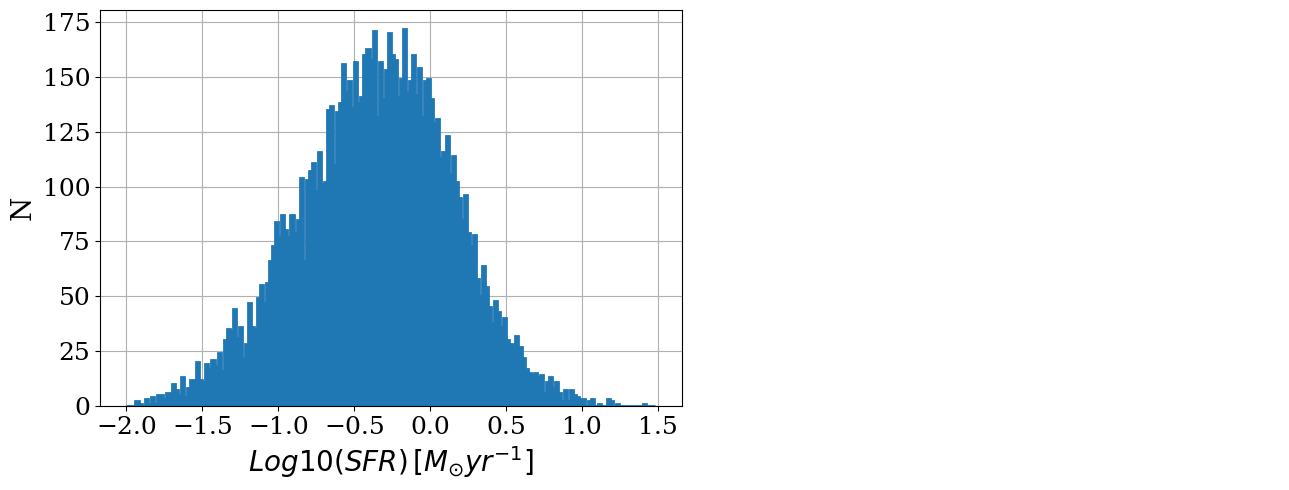

In [154]:
#Now the Historgram:

fig = plt.figure(figsize=(13.,5.))
plt.axes(frameon=False)
plt.xticks([])
plt.yticks([])

ax1 = fig.add_subplot(1,2,1)
d =  SFR_histo
bin_size = np.arange(-2,1.5,0.02) 
plt.hist(d, bins=bin_size, histtype='step', color='C0', fill=True, linewidth=2)
#plt.axvline(1/317.83, color='C1', lw=4, label='Earth')
plt.xticks(family='serif',size=18)
plt.yticks(family='serif',size=18)
ax1.set_xlabel('$Log10(SFR)\,[M_{\odot} yr^{-1}]$', size=20,family='serif')
ax1.set_ylabel('N', size=20,family='serif')
plt.grid(True)
#plt.legend()
#plt.xlim(0.00,13)
plt.tight_layout()

According to the Plor, the star formation rate follows a combination between two Gaussian distributions. The first peak can be identified at -0.7 with a with more spread and the second peak at -0.3 and sharper than the first peak.  

### The Star Forming Main Sequence

A common measure of galaxy mass is its stellar mass M$_{\star}$ in units of M$_{\odot}$, however a galaxy’s mass can be defined in many ways. We can roughly envision that M$_{\star}$ is proxy for galaxy size since larger galaxies typically contain more stars.

## Solution

**4) Make a plot of $log_{10}(SFR)$ vs $log_{10}(M_{\star})$. We have $log_{10}(M_{\star})$ provided in the SDSS data as: gals['lgm_tot_p50']. Plot $log_{10}(M_{\star})$ on the x-axis.**

Based on the plot, how does the SFR correlate with M$_{\star}$?

The expected correlation is the following: 

$$log_{10}(SFR) = log_{10}M_{\star} \times 1.292 - 12.31$$


In [155]:
galaxy_mass_log10 = gals['lgm_tot_p50']
SFR_log10 = SFR_histo

print("The log10(Stellar Mass) array is:")
print(galaxy_mass_log10)

The log10(Stellar Mass) array is:
lgm_tot_p50
-----------
   10.14489
   10.08973
   10.02382
   10.17186
   10.28536
   9.527237
   10.02797
   10.07051
   10.18141
   9.285748
        ...
   9.850113
   9.546258
   9.958274
   10.17375
    10.0226
   10.36474
   10.01672
    10.3127
   9.566533
   9.504778
   10.16343
Length = 10000 rows


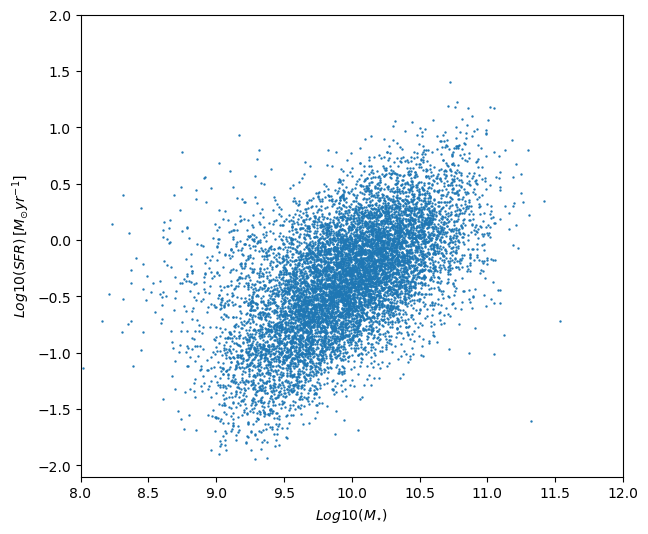

In [156]:
# Correlation Plot

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(galaxy_mass_log10, SFR_log10, s=0.5)
plt.xlabel('$Log10(M_{\star})$')
plt.ylabel('$Log10(SFR)\,[M_{\odot} yr^{-1}]$')
ax.set_xlim(8, 12)
ax.set_ylim(-2.1,2)
plt.show()

As we can observe, the correlation would be linear. That conclusion agrees with the expected correlation which is linear as well.

**5) Make the same plot $log_{10}(SFR)$ vs $log_{10}(M_{\star})$ adding the expected correlation. What can you conclude form this plot? Are there many galaxies that are above the correlation?**

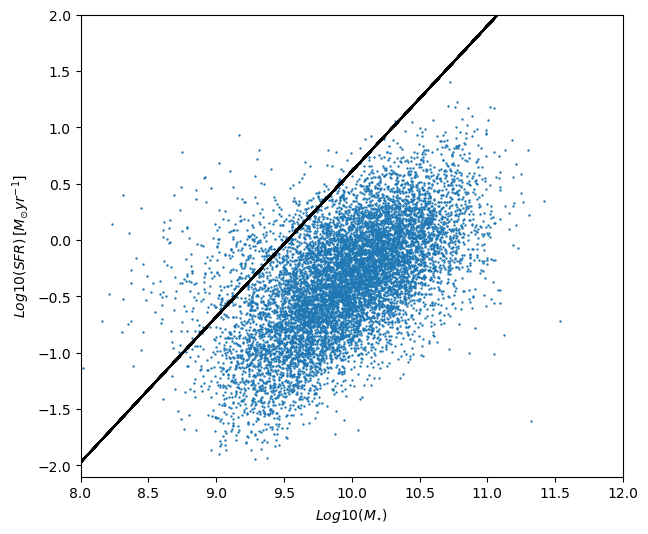

In [157]:
#Expected correlation
corr = 1.292*galaxy_mass_log10 - 12.31

# Correlation Plot

fig = plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)
plt.scatter(galaxy_mass_log10, SFR_log10, s=0.5)
plt.xlabel('$Log10(M_{\star})$')
plt.ylabel('$Log10(SFR)\,[M_{\odot} yr^{-1}]$')
plt.plot(galaxy_mass_log10,corr,'k')
ax.set_xlim(8, 12)
ax.set_ylim(-2.1,2)
plt.show()

According to the plot, there are few galaxiest are over the correlation.

**6) What kind of galaxies are the ones with high star formation rates? Are these spirals or ellipticals? Do these galaxies look blue or red? To answere this, download a sample of images for 16 galaxies for which $log_{10}(SFR)$ is between -0.05 and 0.05. You can use the code below to get the image cutouts.**

In [158]:
#
# Function to display images
#
def get_images(gal_array,description):
    # set thumbnail parameters
    width=200           # image width
    height=200          # height
    pixelsize=0.396     # image scale
    plt.figure(figsize=(15, 15))   # display in a 4x4 grid
    subPlotNum = 1

    i = 0
    new_gals = gal_array
    nGalaxies = len(new_gals)
    for index in range(0,nGalaxies):           # iterate through rows in the DataFrame
        i = i + 1
        if i<17:
            print('Getting image of '+description+str(i)+' of '+str(nGalaxies)+'...')
            if (i == nGalaxies):
                print('Plotting images...')
            scale=2.0*new_gals['petror90_r']/pixelsize/width
            
            pos = coords.SkyCoord(new_gals['ra'][index], new_gals['dec'][index], unit=u.deg, frame='icrs')
            
            cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
            query_string = urlencode(dict(ra=new_gals['ra'][index], dec=new_gals['dec'][index],width=width, height=height, scale=scale[i]))
            url = cutoutbaseurl + '?' + query_string

            # this downloads the image
            image_name = 'cutout_'+str(index)+'.jpg'
            urlretrieve(url, image_name)

            # Display the image
            img = imread(image_name)

            plt.subplot(4,4,subPlotNum)
            subPlotNum += 1
            plt.imshow(img)                               # show images in grid
            plt.title(index)                              # show the object identifier (objId) above the image.

######


In [162]:
print(gals)

plate fiberid  mjd      ra    ... lick_hd_a_sub_err d4000_n_sub_err petror90_r
----- ------- ----- --------- ... ----------------- --------------- ----------
  327     287 52294  172.9785 ...          1.198281       0.0254548   8.838215
  339      81 51692  196.1818 ...         0.7961217        0.017084   6.626981
  334     460 51993 187.38695 ...           1.74312       0.0408858   6.046188
  288     220 52000 184.67267 ...          1.479805      0.04000361   7.443798
  338     104 51694 195.55476 ...            1.7718      0.04822052   9.842375
  467     299 51901 130.58952 ...          1.153155      0.02298255   4.850787
  602     368 52072 195.39459 ...         0.7512083      0.01545298   2.906462
  450     139 51908 136.84324 ...         0.7728633      0.01699663   6.590944
  453     197 51915 146.19562 ...         0.7759885      0.02202449   6.815051
  452     303 51911 140.69285 ...          1.276988      0.02906865   8.664083
  ...     ...   ...       ... ...               ... 

In [163]:
#First, include log10(SFR) in the Data Cube:

gals['log10(SFR)'] = SFR_log10

#gals
print(gals)

plate fiberid  mjd  ... d4000_n_sub_err petror90_r       log10(SFR)     
----- ------- ----- ... --------------- ---------- ---------------------
  327     287 52294 ...       0.0254548   8.838215   -0.5896148124031491
  339      81 51692 ...        0.017084   6.626981  -0.12169001873649833
  334     460 51993 ...       0.0408858   6.046188 -0.056338322269192685
  288     220 52000 ...      0.04000361   7.443798   -0.3273227468654982
  338     104 51694 ...      0.04822052   9.842375   -0.7682990152248395
  467     299 51901 ...      0.02298255   4.850787   -0.4560807128606934
  602     368 52072 ...      0.01545298   2.906462    0.1974242930876707
  450     139 51908 ...      0.01699663   6.590944  -0.05769934967679086
  453     197 51915 ...      0.02202449   6.815051   -0.5928115808158827
  452     303 51911 ...      0.02906865   8.664083    -0.970298855469085
  ...     ...   ... ...             ...        ...                   ...
 2133     467 53917 ...       0.0282685   5.916755 

In [169]:
#Create a copy of the original data cube
gals1=gals
#print(gals1)

In [166]:
#Now, select the data with the specified range for log10(SFR) in the copy of the data cube
print(len(gals1))

# quality cuts, these are important to make sure that we only have galaxies in the sample
gals1 = gals1[gals1['log10(SFR)'] < 0.05]
gals1 = gals1[gals1['log10(SFR)'] > -0.05]

print(len(gals1))

10000
693


In [167]:
candidates_to_images = gals1 

Getting image of high SFR galaxy 1 of 693...
Getting image of high SFR galaxy 2 of 693...
Getting image of high SFR galaxy 3 of 693...
Getting image of high SFR galaxy 4 of 693...
Getting image of high SFR galaxy 5 of 693...
Getting image of high SFR galaxy 6 of 693...
Getting image of high SFR galaxy 7 of 693...
Getting image of high SFR galaxy 8 of 693...
Getting image of high SFR galaxy 9 of 693...
Getting image of high SFR galaxy 10 of 693...
Getting image of high SFR galaxy 11 of 693...
Getting image of high SFR galaxy 12 of 693...
Getting image of high SFR galaxy 13 of 693...
Getting image of high SFR galaxy 14 of 693...
Getting image of high SFR galaxy 15 of 693...
Getting image of high SFR galaxy 16 of 693...


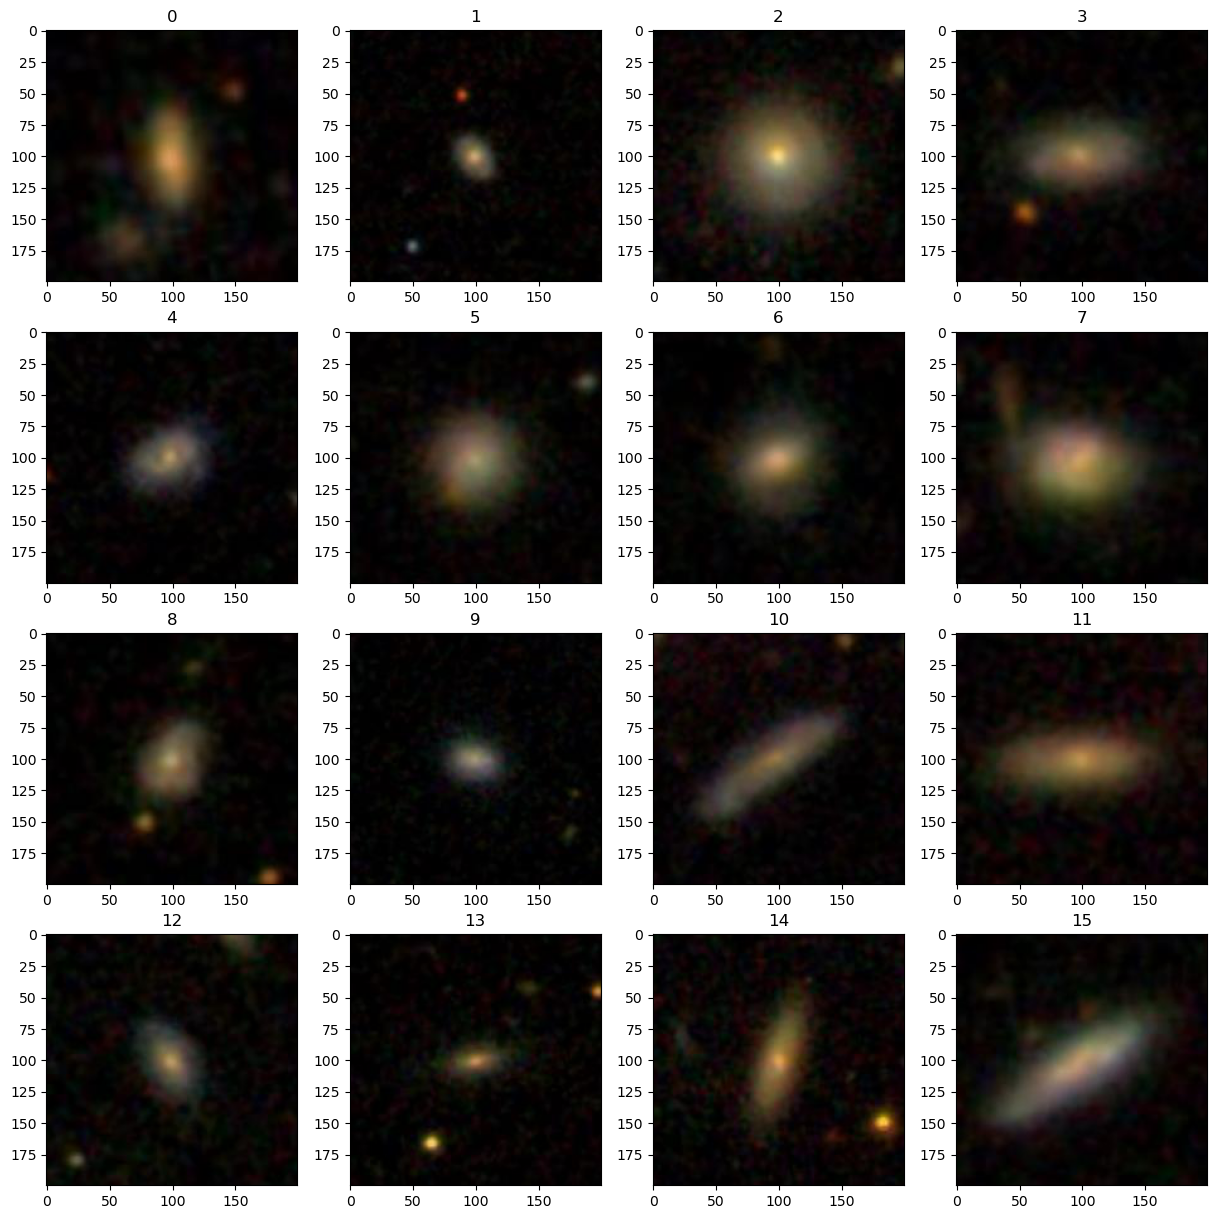

In [168]:
get_images(candidates_to_images,'high SFR galaxy ') # call function with filtered galaxy array

**7)  What kind of galaxies are the ones with low star formation rates? Are these spirals or ellipticals? Do these galaxies look blue or red? To answere this, download a sample of images for 16 galaxies for which $log_{10}(SFR)$ is between -1.55 and -1.45. You can use the code below to get the image cutouts.**


In [171]:
#Create a copy of the original data cube
gals2=gals
#print(gals2)

In [172]:
#Now, select the data with the specified range for log10(SFR) in the copy of the data cube
print(len(gals2))

# quality cuts, these are important to make sure that we only have galaxies in the sample
gals2 = gals2[gals2['log10(SFR)'] < -1.45]
gals2 = gals2[gals2['log10(SFR)'] > -1.55]

print(len(gals2))

10000
76


In [173]:
candidates_to_images_2 = gals2 

Getting image of high SFR galaxy 1 of 76...
Getting image of high SFR galaxy 2 of 76...
Getting image of high SFR galaxy 3 of 76...
Getting image of high SFR galaxy 4 of 76...
Getting image of high SFR galaxy 5 of 76...
Getting image of high SFR galaxy 6 of 76...
Getting image of high SFR galaxy 7 of 76...
Getting image of high SFR galaxy 8 of 76...
Getting image of high SFR galaxy 9 of 76...
Getting image of high SFR galaxy 10 of 76...
Getting image of high SFR galaxy 11 of 76...
Getting image of high SFR galaxy 12 of 76...
Getting image of high SFR galaxy 13 of 76...
Getting image of high SFR galaxy 14 of 76...
Getting image of high SFR galaxy 15 of 76...
Getting image of high SFR galaxy 16 of 76...


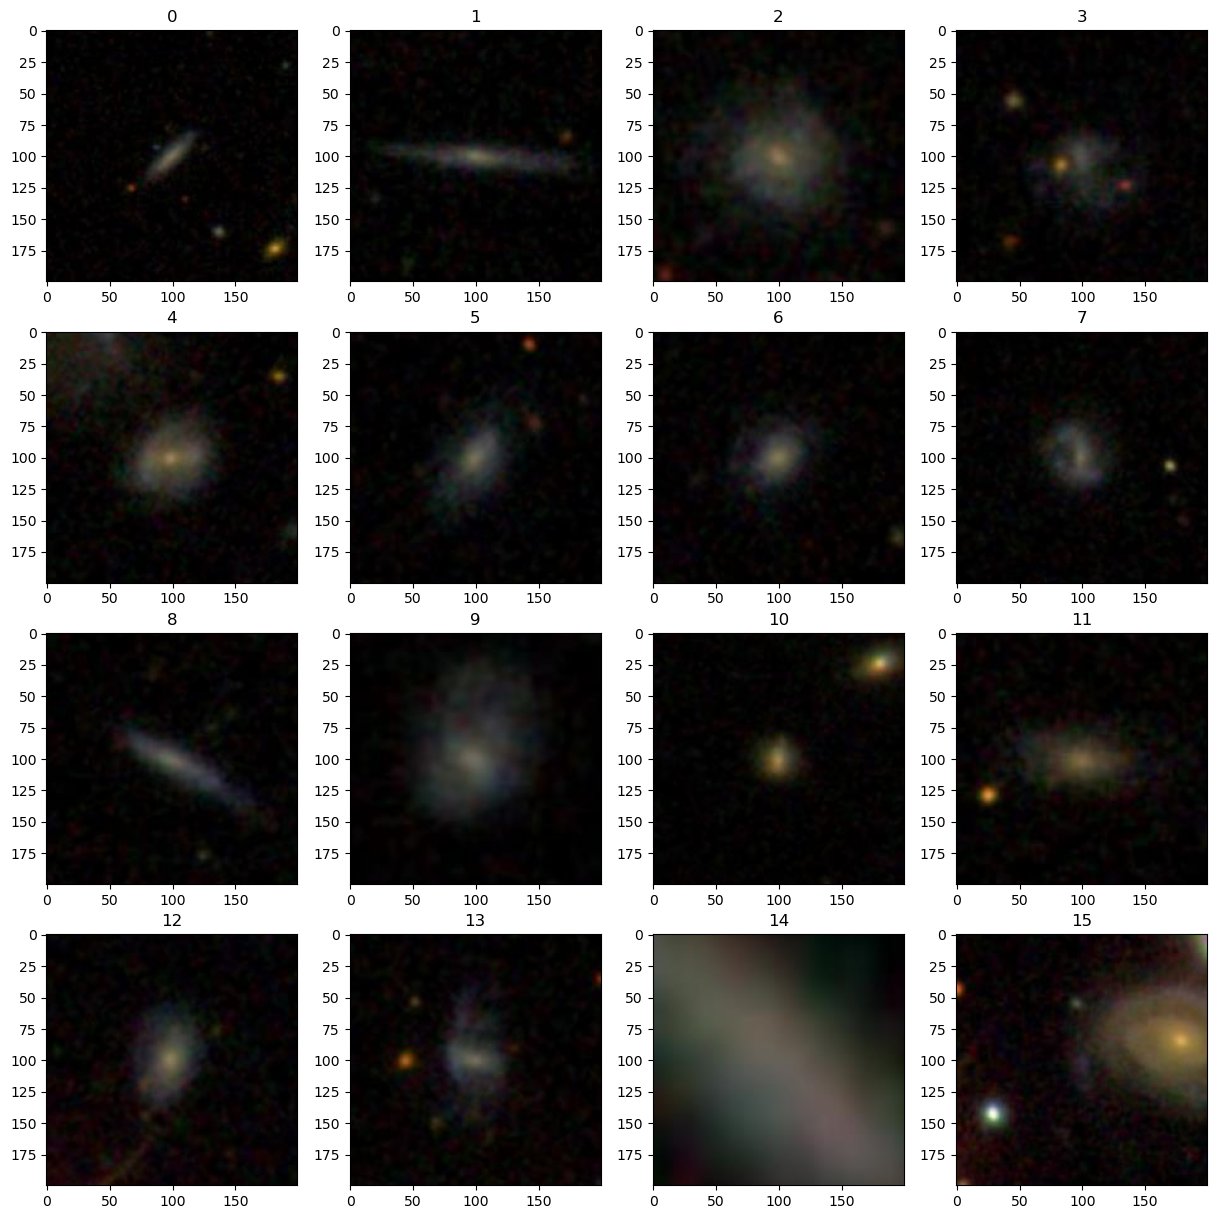

In [174]:
get_images(candidates_to_images_2,'high SFR galaxy ') # call function with filtered galaxy array

Galaxies can deviate from the Main Sequence (the line that we plotted) on the SFR-M$_{\star}$ diagram. At a given M$_{\star}$, <b>starburst galaxies have 10x the SFR of the Main Sequence galaxies,</b> while <b>quiescent galaxies have a 0.01x the SFR of the Main Sequence galaxies</b>. 

8) Use these definitions to add two more lines to the $log_{10}(SFR)$ vs $log_{10}(M_{\star})$ plot denoting the location of starbursts and quiescent galaxies.

### The specific star formation rate

It becomes evident from this plot that when we want to identify a highly star forming galaxy, the metric we’re usually after is the specific star formation rate sSFR. It is defined as

$$sSFR = \frac{SFR}{M_{\star}}$$ 

and represents ratio of current star formation to past star formation, or the growth rate of stellar mass in a galaxy. We can add the sSFR to our dataframe to explore the metric in detail.

9) Calcualte the $log_{10}(sSFR)$ and make a histogram of $log_{10}(sSFR)$. Does this histogram look similar to the $log_{10}(SFR)$ histogram? 

10) Get images of galaxies with high sSFR (sSFR > -10) and low sSFR (sSFR < 11.5). These are starburst galaxies and quiescent galaxies. Do these galaxies look the same as the high and low SFR galaxies? Do you see any differences? 